In [1]:
from abc import abstractmethod
from typing import Iterator, Any
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.loggers import Logger
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchmetrics import R2Score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [2]:
def morgan_counts_features(
    sm: str,
    radius: int = 2,
    num_bits: int = 1024,
) -> np.ndarray:
    """
    Generates a counts-based Morgan fingerprint for a molecule.

    :param sm: smiles string
    :param radius: Morgan fingerprint radius.
    :param num_bits: Number of bits in Morgan fingerprint.
    :return: A 1D numpy array containing the counts-based Morgan fingerprint.
    """
    mol = Chem.MolFromSmiles(sm) 
    features_vec = AllChem.GetHashedMorganFingerprint(mol, radius, nBits=num_bits)
    features = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(features_vec, features)

    return features


class InMemoryLogger(Logger):
    """somewhat hacky way to use lightning to track metrics in memory for quick experiments"""
    def __init__(self):
        super().__init__()
        self.metrics = defaultdict(list)
        self.hps = None

    def log_metrics(self, metrics: dict[str, float], step: int = None):
        for metric, value in metrics.items():
            self.metrics[metric].append(value)

    @property
    def name(self):
        return "in_memory_logger"

    def log_hyperparams(self, params: dict[str, float], **kwargs):
        self.hps = params

    @property
    def version(self):
        return "0.0"


def never_nan_log(
    x: torch.Tensor, eps: float = 1e-20,
) -> torch.Tensor:
    return torch.clip(x, eps).log()


class BaseLightning(LightningModule):
    def _configure_optimizers(self, parameters: Iterator[torch.nn.Parameter]):
        opt = optim.AdamW(
            parameters, lr=self.hparams.lr, weight_decay=self.hparams.wd,
        )
        scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.hparams.max_iter)
        return [opt], [{"scheduler": scheduler, "interval": "step"}]

    def configure_optimizers(self):
        return self._configure_optimizers(self.parameters())

    def training_step(self, batch: list[torch.Tensor]) -> torch.Tensor:
        return self.get_loss(batch, "train")

    def validation_step(self, batch: list[torch.Tensor], *args) -> torch.Tensor:
        return self.get_loss(batch, "val")
    
    def test_step(self, batch: list[torch.Tensor], *args) -> torch.Tensor:
        return self.get_loss(batch, "test")

    @abstractmethod
    def get_loss(self, batch: list[torch.Tensor], prefix: str) -> torch.Tensor:
        pass

    def epoch_log(
        self,
        name: str,
        value: torch.Tensor,
    ) -> None:
        super().log(name, value, on_epoch=True, on_step=False)


class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden: int, n_hidden: int, output_dim: int = None):
        super().__init__()
        output_dim = output_dim or hidden
        self.model = nn.Sequential(
            nn.Sequential(nn.Linear(input_dim, hidden), nn.GELU()),
        )
        for _ in range(n_hidden):
            self.model.append(
                nn.Sequential(nn.Linear(hidden, hidden), nn.GELU()),
            )
        self.model.append(nn.Linear(hidden, output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

                                        
class RegressionMLP(BaseLightning):
    def __init__(
        self, input_dim: int, n_outputs: int, max_iter: int,
        lr: float=1e-3, wd: float = 0,
        hidden: int = 128, n_hidden: int = 1,
        target_names: list[str] = None,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.hparams.target_names = (
            self.hparams.target_names 
            or [f"target_{i}" for i in range(n_outputs)]
        )
        
        self.mlp = MLP(
            input_dim=input_dim, hidden=hidden, n_hidden=n_hidden, output_dim=n_outputs,
        )        
        self.loss = nn.MSELoss()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)
    
    def get_loss(self, batch: list[torch.Tensor], prefix: str) -> torch.Tensor:
        pred = self(batch[0])
        loss = self.loss(pred, batch[1])
        
        with torch.no_grad():
            for i, target_name in enumerate(self.hparams.target_names):
                target_loss = self.loss(pred[:, i], batch[1][:, i])
                self.epoch_log(f"{prefix}/{target_name}_loss", target_loss)

                r2_score = R2Score()
                target_r2 = r2_score(pred[:, i].cpu(), batch[1][:, i].cpu())
                # print(len(pred[:, i]), len(batch[1][:, i]))
                self.epoch_log(f"{prefix}/{target_name}_R2", target_r2)
        
        self.epoch_log(f"{prefix}/loss", loss)
        return loss

# prepare data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv")

In [4]:
features = process_map(morgan_counts_features, df["smiles"], max_workers=1)
print(features.shape)

/tmp/ipykernel_2674509/2162562590.py:1: TqdmWarning: Iterable length 249455 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  features = process_map(morgan_counts_features, df["smiles"], max_workers=1)


In [5]:
print(len(features))
print(max(features[0]))
print(max(features[1]))
print(max(features[2]))



249455
8.0
4.0
13.0


249455

In [ ]:
# df[["logP", "qed", "SAS"]].values
# len(df[["logP", "qed", "SAS"]].values)

print(df[["logP", "qed", "SAS"]].values.shape)

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    features, df[["logP", "qed", "SAS"]].values, random_state=13141,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=11, test_size=0.1,
)

print(len(X_train), len(X_val), len(X_test))

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

scaler.mean_, scaler.scale_
# # De-normalize the predictions
# de_normalized_predictions = predictions * scaler.scale_ + scaler.mean_

168381 18710 62364


(array([2.45937151, 0.72798518, 3.05305882]),
 array([1.43333361, 0.13968419, 0.83458114]))

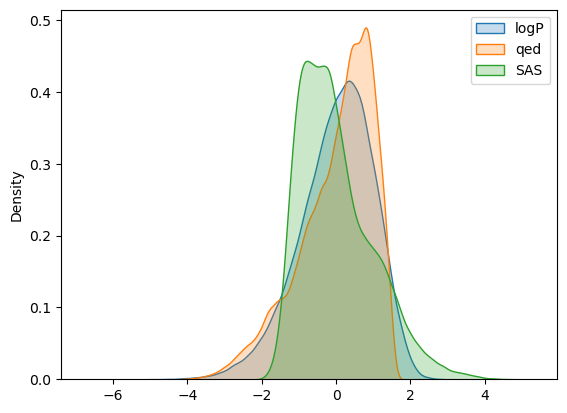

In [7]:
import warnings

# Ignore specific FutureWarnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    for i, label in enumerate(["logP", "qed", "SAS"]):
        sns.kdeplot(y_train[:, i], label=label, fill=True)
    plt.legend()
    plt.show()

In [8]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

train_dset = TensorDataset(
    torch.tensor(X_train_np, dtype=torch.float32), torch.tensor(y_train_np, dtype=torch.float32),
)
val_dset = TensorDataset(
    torch.tensor(X_val_np, dtype=torch.float32), torch.tensor(y_val_np, dtype=torch.float32),
)
test_dset = TensorDataset(
    torch.tensor(X_test_np, dtype=torch.float32), torch.tensor(y_test_np, dtype=torch.float32),
)

In [9]:
batch_size = 128
train_loader = DataLoader(
    train_dset, batch_size=batch_size, shuffle=True,
)
val_loader = DataLoader(
    val_dset, batch_size=batch_size, shuffle=True,
)
test_loader = DataLoader(
    test_dset, batch_size=batch_size, shuffle=False,
)

# Prepare model

In [10]:
epochs = 50
sample_batch = next(train_loader.__iter__())
sample_batch[0].shape, sample_batch[1].shape

model = RegressionMLP(
    1024, 3, max_iter=100 * epochs,
    target_names=["logP", "qed", "SAS"],
).cuda()
# make sure more runs
model.get_loss((sample_batch[0].cuda(), sample_batch[1].cuda()), "sample")

/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/pytorch_lightning/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(1.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

# train model

In [11]:
logger = InMemoryLogger()
trainer = Trainer(
    accelerator="gpu",
    limit_train_batches=100,
    limit_val_batches=10,
    log_every_n_steps=100,
    logger=logger,
    max_epochs=epochs,
    enable_progress_bar=False,
    callbacks=[
        LearningRateMonitor(),
        EarlyStopping(monitor="val/loss", mode="min", patience=5),
        ModelCheckpoint(
            "./property_fp_model/",
            monitor="val/loss",
        ),
    ],
)
trainer.fit(
    model=model, train_dataloaders=train_loader, val_dataloaders=val_loader,
)

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /data/yulai/projects/mol_prop/property_fp_model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]

  | Name | Type    | Params
---------------------------------
0 | mlp  | MLP     | 148 K 
1 | loss | MSELoss | 0     
---------------------------------
148 K     Trainable params
0         Non-trainable params
148 K     Total params
0.592     Total estimated mod

# plot results

dict_keys(['lr-AdamW', 'val/logP_loss', 'val/logP_R2', 'val/qed_loss', 'val/qed_R2', 'val/SAS_loss', 'val/SAS_R2', 'val/loss', 'epoch', 'train/logP_loss', 'train/logP_R2', 'train/qed_loss', 'train/qed_R2', 'train/SAS_loss', 'train/SAS_R2', 'train/loss'])


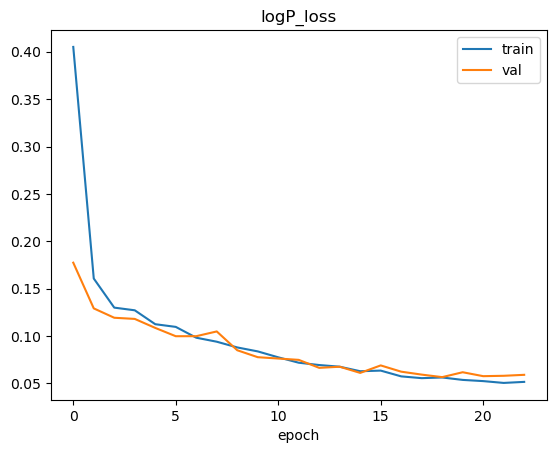

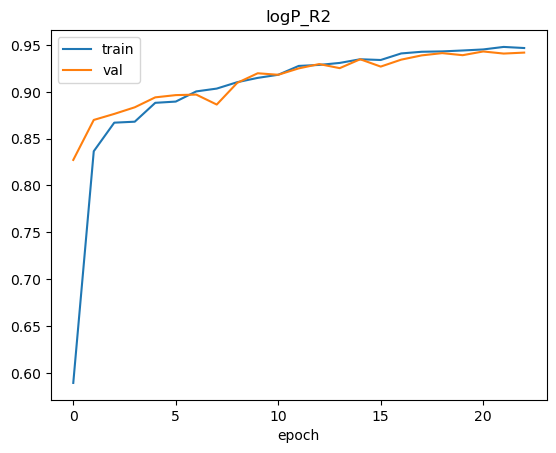

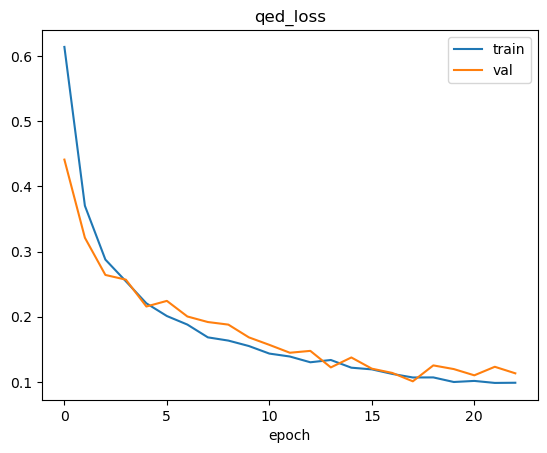

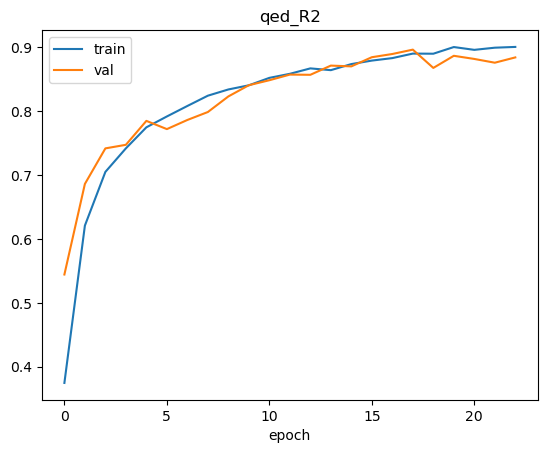

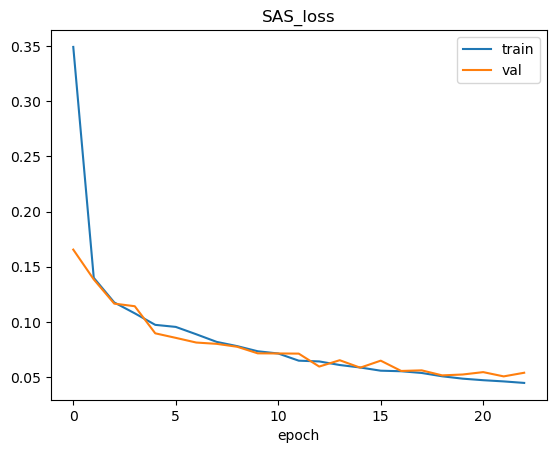

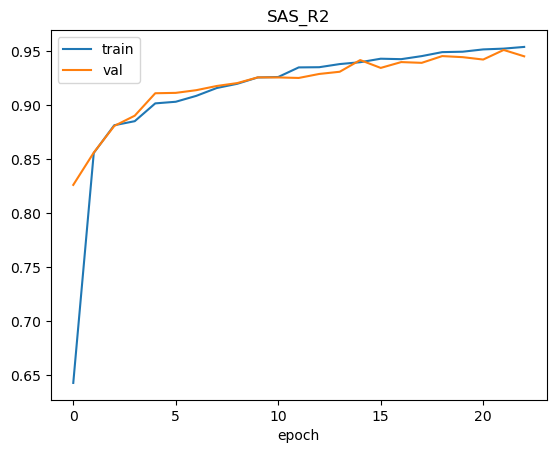

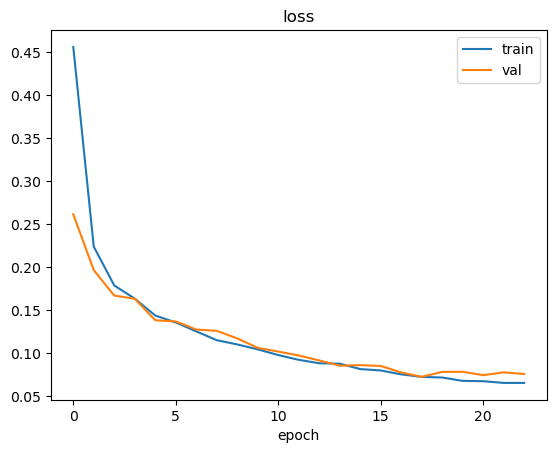

In [12]:
print(logger.metrics.keys())

for name, values in logger.metrics.items():
    if not name.startswith("train/"):
        continue
    plt.title(name[6:])
    plt.plot(values, label="train")
    plt.plot(logger.metrics[name.replace("train/", "val/")], label="val")
    plt.legend()
    plt.xlabel("epoch")
    plt.show()

In [13]:
trainer.test(model=model, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test/SAS_R2          0.9487412571907043
      test/SAS_loss         0.05024448037147522
      test/logP_R2          0.9426528811454773
     test/logP_loss        0.056402385234832764
        test/loss           0.07381253689527512
       test/qed_R2          0.8814312219619751
      test/qed_loss         0.1147909015417099
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/logP_loss': 0.056402385234832764,
  'test/logP_R2': 0.9426528811454773,
  'test/qed_loss': 0.1147909015417099,
  'test/qed_R2': 0.8814312219619751,
  'test/SAS_loss': 0.05024448037147522,
  'test/SAS_R2': 0.9487412571907043,
  'test/loss': 0.07381253689527512}]